In [1]:
import tempfile
import numpy as np
import pandas as pd
from scipy.optimize import minimize, least_squares
from scipy.stats import gamma, norm
import matplotlib.pyplot as plt

def calcular_hmax(media, desvio_padrao, tempo_retorno):
    """
    Determina a precipitação máxima diária para tempos de retorno específicos.
    """
    return media - desvio_padrao * (0.45 + 0.7797 * np.log(np.log(tempo_retorno / (tempo_retorno - 1))))

def desagragacao_preciptacao(h_max1):
    """
    Estima precipitações máximas para diferentes durações a partir do valor diário.
    """
    dados_hmax = {'td (min)': [1440, 720, 600, 480, 360, 180, 60, 30, 25, 20, 15, 10, 5]}
    multiplicadores = [0.85, 0.78, 0.72, 0.54, 0.48, 0.42, 0.74, 0.91, 0.81, 0.7, 0.54, 0.34]
    for i, valor in enumerate(['2', '5', '10', '15', '20', '25', '50', '100', '250', '500', '1000']):
        h_max = [0] * 13
        h_max[0] = h_max1[i] * 1.14
        for j in range(1, len(multiplicadores) + 1):
            if j <= 6:
                h_max[j] = h_max[0] * multiplicadores[j - 1]
            elif j == 7:
                h_max[j] = h_max[6] * multiplicadores[j - 1]
            else:
                h_max[j] = h_max[7] * multiplicadores[j - 1]
        dados_hmax[valor] = h_max
    return pd.DataFrame(dados_hmax)

def conversao_intensidade(preciptacao):
    """
    Converte precipitações em intensidades (mm/h).
    """
    divisores = [5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 6, 8, 12, 24]
    divisores.reverse()
    def multiply_row(row):
        return row[:-1] / divisores  # assume 'td (min)' está na última coluna
    intensidades = preciptacao.copy()
    intensidades.iloc[:, 1:-1] = intensidades.iloc[:, 1:-1].apply(lambda col: col / divisores[intensidades.columns.get_loc(col.name)-1])
    return intensidades

def calculo_precipitacoes(df_inmet):
    """
    Processa dados de precipitação diária para gerar hmax, precipitações, intensidades e tabela IDF.
    """
    df = df_inmet.copy()
    if 'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)' in df.columns:
        df.rename(columns={'PRECIPITACAO TOTAL, DIARIO (AUT)(mm)': 'PRECIPITACAO TOTAL DIARIA (mm)'}, inplace=True)
    elif 'PRECIPITACAO TOTAL, DIARIO(mm)' in df.columns:
        df.rename(columns={'PRECIPITACAO TOTAL, DIARIO(mm)': 'PRECIPITACAO TOTAL DIARIA (mm)'}, inplace=True)
    elif 'PRECIPITACAO TOTAL DIARIA (mm)' not in df.columns:
        raise ValueError("Coluna de precipitação não encontrada.")

    df['Data Medicao'] = pd.to_datetime(df['Data Medicao'])
    df['ano hidrológico'] = df['Data Medicao'].dt.year
    df['PRECIPITACAO TOTAL DIARIA (mm)'] = pd.to_numeric(df['PRECIPITACAO TOTAL DIARIA (mm)'], errors='coerce')
    df.dropna(subset=['PRECIPITACAO TOTAL DIARIA (mm)'], inplace=True)

    maiores_precipitacoes_por_ano = df.groupby('ano hidrológico')['PRECIPITACAO TOTAL DIARIA (mm)'].max()
    media = maiores_precipitacoes_por_ano.mean()
    desvio_padrao = maiores_precipitacoes_por_ano.std()

    tempo_retorno = [2, 5, 10, 15, 20, 25, 50, 100, 250, 500, 1000]
    h_max1 = [calcular_hmax(media, desvio_padrao, tr) for tr in tempo_retorno]
    h_max1aux = pd.DataFrame({'tempo de retorno (anos)': tempo_retorno, 'Pmax diária (mm)': h_max1})

    preciptacao = desagragacao_preciptacao(h_max1)
    intensidade = conversao_intensidade(preciptacao)

    df_longo = intensidade.melt(id_vars='td (min)', var_name='tr', value_name='y_obs (mm/h)')
    df_longo['tr'] = df_longo['tr'].astype(float)

    return h_max1aux, preciptacao, intensidade, df_longo, media, desvio_padrao

def problema_inverso_idf(df_long):
    """Está função determina os parâmetros da equação IDF a partir dos dados de intensidade de preciptação máxima diária.
    
    Args:
        df_long (DataFrame): DataFrame com os valores de intensidade de preciptação máxima diária para os tempos de retorno selecionados (mm/h)
        
    Returns:
        a_opt (Float): Parâmetro a da equação IDF
        b_opt (Float): Parâmetro b da equação IDF
        c_opt (Float): Parâmetro c da equação IDF
        d_opt (Float): Parâmetro d da equação IDF
    """

    # Dados para confecção do IDF
    t_r = df_long['tr'].values 
    t_c = df_long['td (min)'].values  
    y_obs = df_long['y_obs (mm/h)'].values 

    # Equação de predição do IDF
    def model_function(params, t_r, t_c):
        a, b, c, d = params
        return (a * t_r ** b) / (t_c + c)**d

    # Equação de erro
    def error_function(params, t_r, t_c, y_obs):
        y_pred = model_function(params, t_r, t_c)
        error = np.mean((y_pred - y_obs) ** 2)
        return error

    # Problema inverso
    initial_guess = [0, 0, 0, 0]
    bounds = [(1e-5, None), (1e-5, None), (1e-5, None), (1e-5, None)]
    result = minimize(error_function, initial_guess, args=(t_r, t_c, y_obs), bounds=bounds)
    a_opt, b_opt, c_opt, d_opt = result.x

    return a_opt, b_opt, c_opt, d_opt

In [2]:
df_estacao = pd.read_csv('dados_A001_D_2000-05-06_2025-04-25.csv', sep=";", encoding="utf-8", skiprows=9)
df_estacao

,Data Medicao,"PRECIPITACAO TOTAL, DIARIO (AUT)(mm)","TEMPERATURA MEDIA, DIARIA (AUT)(°C)","UMIDADE RELATIVA DO AR, MEDIA DIARIA (AUT)(%)","VENTO, VELOCIDADE MEDIA DIARIA (AUT)(m/s)",Unnamed: 5
0,2000-05-06,NaN,NaN,NaN,NaN,NaN
1,2000-05-07,NaN,NaN,49.2,NaN,NaN
2,2000-05-08,0.0,22.1,60.3,2.1,NaN
3,2000-05-09,0.0,22.1,58.8,1.2,NaN
4,2000-05-10,0.0,22.4,62.1,2.1,NaN
...,...,...,...,...,...,...
9116,2025-04-21,0.0,22.5,77.0,1.2,NaN
9117,2025-04-22,0.0,21.9,81.2,1.5,NaN
9118,2025-04-23,0.2,22.6,79.1,1.7,NaN
9119,2025-04-24,0.0,22.9,75.0,2.0,NaN


In [3]:
_, _, _, df_longo, _, _ = calculo_precipitacoes(df_estacao)
display(df_longo)

,td (min),tr,y_obs (mm/h)
0,1440,2.0,3.407857
1,720,2.0,2.896678
2,600,2.0,2.658128
3,480,2.0,2.453657
4,360,2.0,1.840243
...,...,...,...
138,25,1000.0,48.950826
139,20,1000.0,43.571614
140,15,1000.0,37.654481
141,10,1000.0,29.047743


In [4]:
params = problema_inverso_idf(df_longo)
print("Parâmetros ajustados:", params)

Parâmetros ajustados: (np.float64(17.020662208569387), np.float64(0.3404144885592611), np.float64(1.0589247734465693e-05), np.float64(1e-05))


In [5]:
a, b, c, d = params
df_longo['y_pred'] = (a * df_longo['tr']**b) / ((df_longo['td (min)'] + c)**d)
df_longo


,td (min),tr,y_obs (mm/h),y_pred
0,1440,2.0,3.407857,21.548639
1,720,2.0,2.896678,21.548788
2,600,2.0,2.658128,21.548827
3,480,2.0,2.453657,21.548876
4,360,2.0,1.840243,21.548938
...,...,...,...,...
138,25,1000.0,48.950826,178.733491
139,20,1000.0,43.571614,178.733890
140,15,1000.0,37.654481,178.734404
141,10,1000.0,29.047743,178.735129


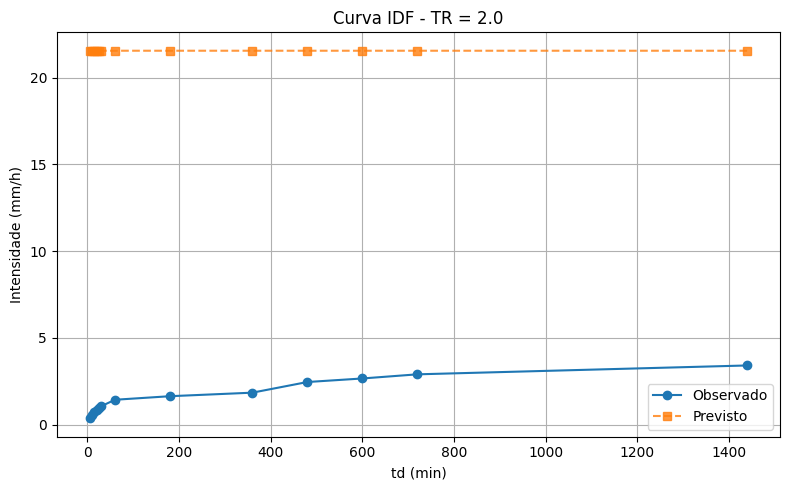

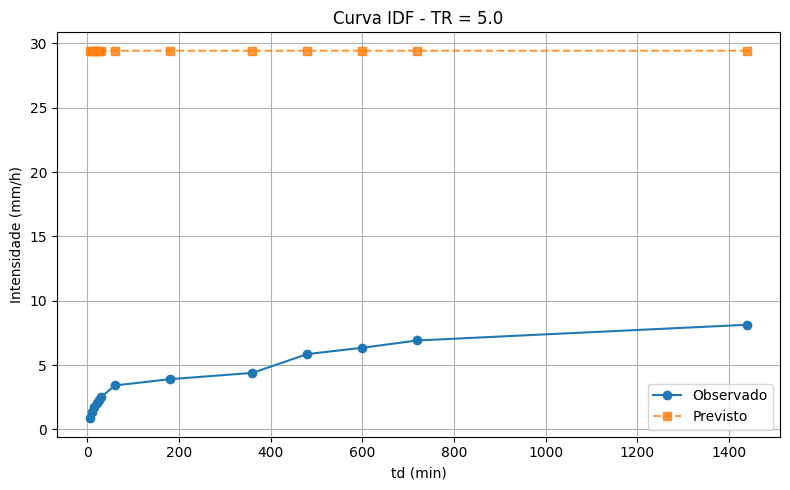

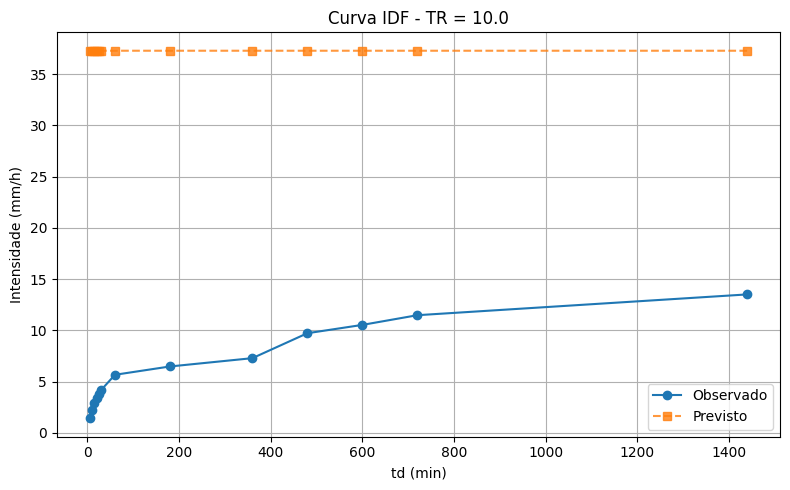

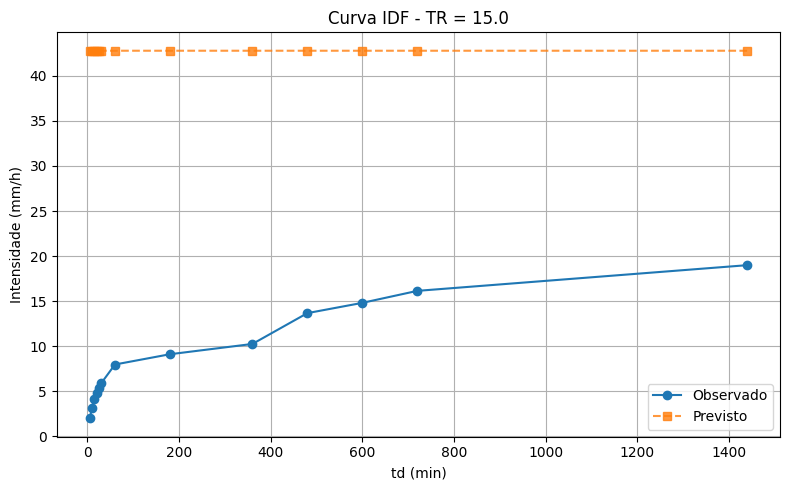

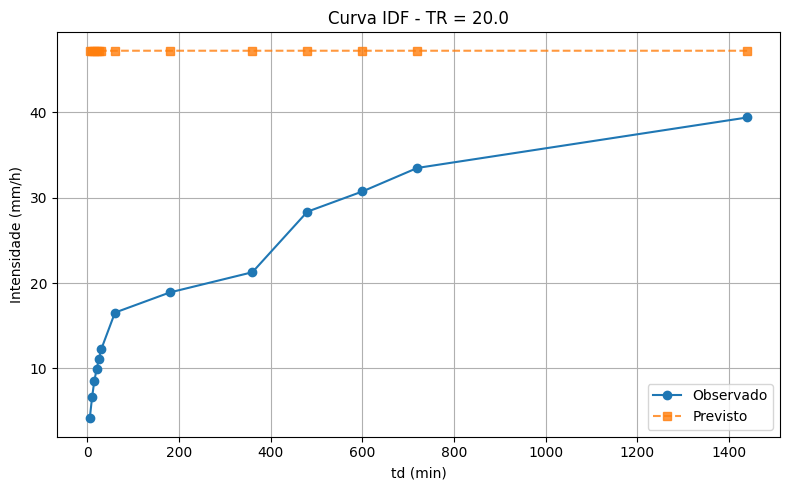

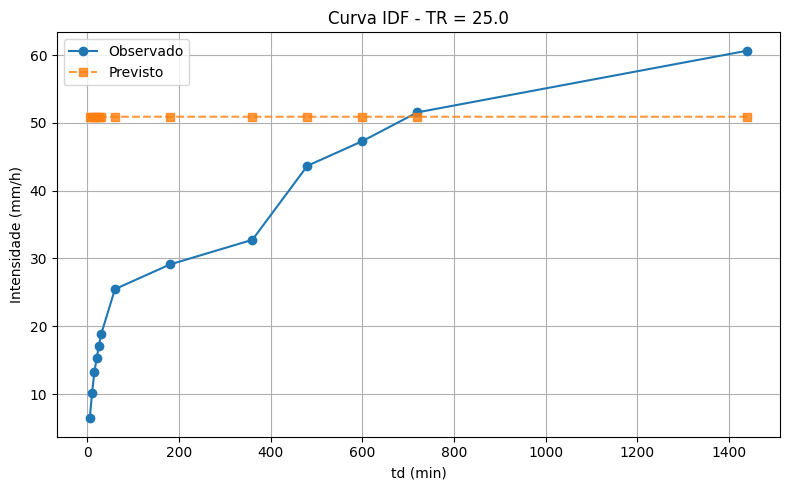

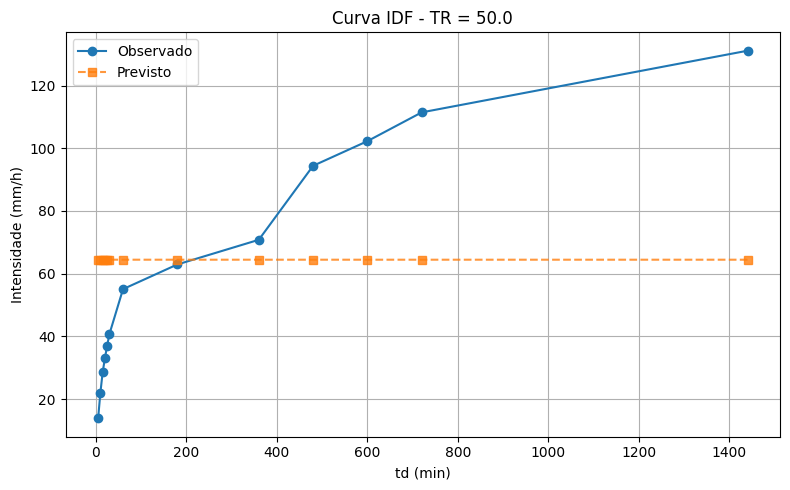

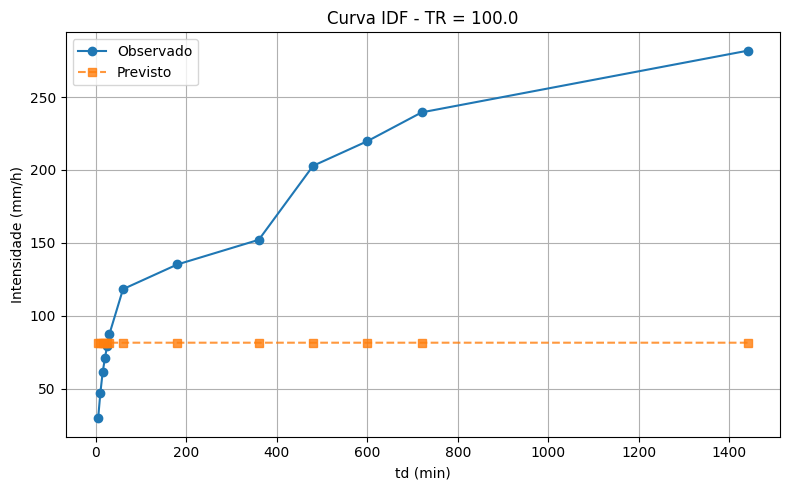

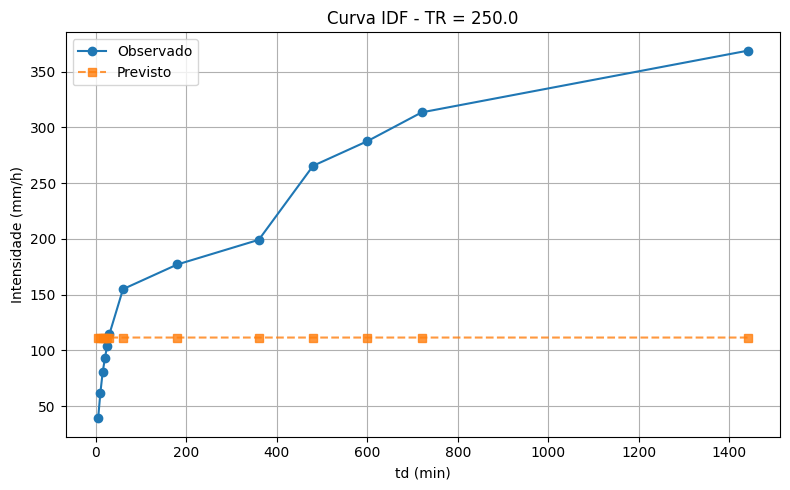

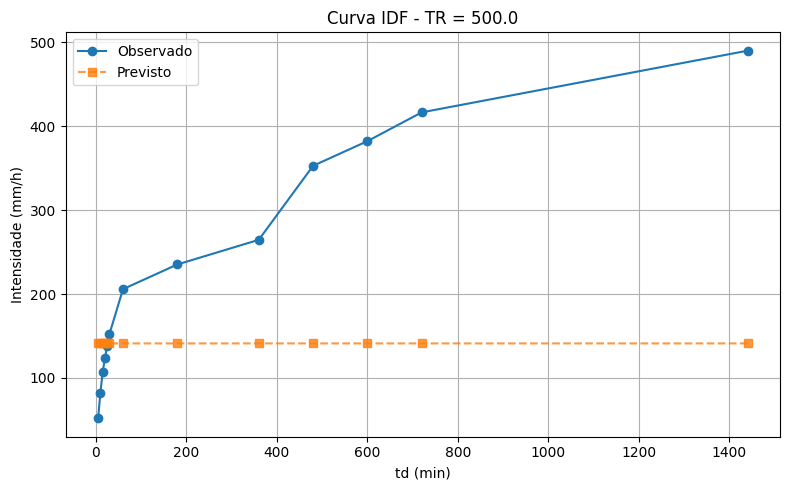

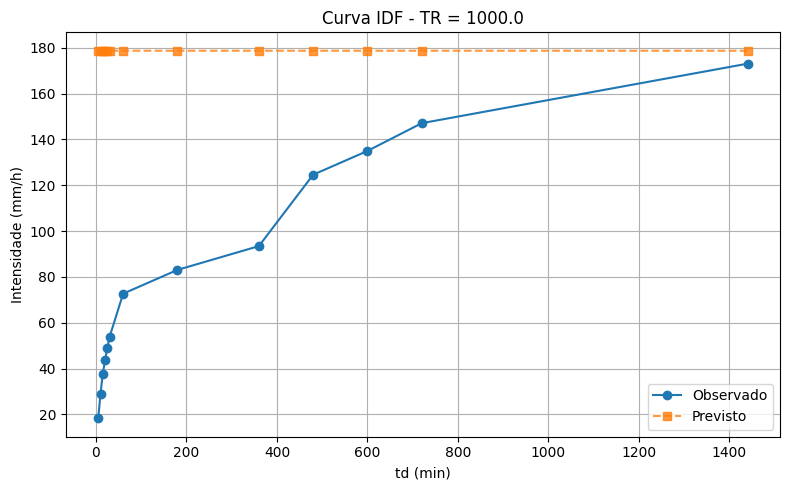

In [6]:
for tr_val, grupo in df_longo.groupby('tr'):
    plt.figure(figsize=(8, 5))
    plt.plot(grupo['td (min)'], grupo['y_obs (mm/h)'], 'o-', label='Observado')
    plt.plot(grupo['td (min)'], grupo['y_pred'], 's--', label='Previsto', alpha=0.8)
    plt.title(f"Curva IDF - TR = {tr_val}")
    plt.xlabel("td (min)")
    plt.ylabel("Intensidade (mm/h)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()